## lets begin with step by step process

In [ ]:
After making all the models i am making now all 3 different model for doing the process
    the command o am using is 



*Objective:* Simulate a chess game where the bot plays in the style of a selected well-known chess player.

### 1. Human Player Selection
- *Instruction:* Please choose a well-known chess player from the following list:
  1. Magnus Carlsen
  2. Garry Kasparov
  3. Hikaru Nakamura
  4. Judit Polgar
  5. Bobby Fischer
  6. Anatoly Karpov
  7. Viswanathan Anand
  8. Levon Aronian
  9. Veselin Topalov
  10. Fabiano Caruana
  - (Add more players as needed)

### 2. Move Prediction Process
- *Chess Engine Utilization:* The chess engine (e.g., Stockfish) will generate the top 10 potential moves for the current position.

### 3. Machine Learning Models
- *Predictions:* The following models will analyze the generated moves to simulate the chosen player's style:
  - *Piece Movement Model:* Determines which piece the player is likely to move.
  - *Position Model:* Identifies the square or position the selected player would prefer.
  - *Time Management Model:* Predicts how long the player would take for the move.
  - *Resignation/Draw Model:* Evaluates the likelihood of the player resigning, offering a draw, or continuing the game.

### 4. Game Flow
human will select the player he waana play
the mode of game = Rapid blitz and classic
then
- *Human Opponent's Turn:* After the human opponent makes their move, the bot will respond with a move based on the selected player's style.
- *Alternating ai Turns:* The game will proceed with alternating turns, where each player takes their move based on the strategies discussed

### 5. Continuous Analysis
- *Updating the Game:* After each move (from either the human or the bot), the chess engine and machine learning models will reanalyze the game position to provide predictions for the next move.

---

### Example Interaction
1. *Human Player Selection:* "I choose Garry Kasparov."
2. *Bot Response:* Analyzes the current position using the chess engine and ML models to simulate a move in Kasparov's style.
3. *Human Opponent's Turn:* "I move e4."
4. *Bot Response:* "Kasparov responds with Nf6."

### End of Game
- The game continues until a checkmate, draw, or resignation occurs. At any point, players can review the game state and predictions made by the bot.

---


the coding part i done yet

# Display the top 50 players by game count
top_50_players = pd.concat([df['White'], df['Black']]).value_counts().head(50).index.tolist()
print("Top 50 Players:", top_50_players)

# Ask the user to select a player
selected_player = input("Select a player from the top 50 to play against: ").strip().lower()

# Filter dataset for games where the selected player is either White or Black
player_data = df[(df['White'].str.lower() == selected_player) | (df['Black'].str.lower() == selected_player)]
print(f"Number of games available for {selected_player}: {len(player_data)}")
import chess
import chess.engine

# Initialize lists to store the selected player’s moves and opponent moves
player_moves = []
opponent_moves = []

# Separate games where the player is White or Black
for _, row in player_data.iterrows():
    if row['White'].strip().lower() == selected_player:
        # Player is White in this game
        player_moves.append(eval(row['WhiteMoves']))
        opponent_moves.append(eval(row['BlackMoves']))
    else:
        # Player is Black in this game
        player_moves.append(eval(row['BlackMoves']))
        opponent_moves.append(eval(row['WhiteMoves']))

print(f"Total games processed for {selected_player} as White or Black: {len(player_moves)}")
# Define piece values for material evaluation
piece_values = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0,
                'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k': 0}

def calculate_material_advantage(board):
    """Calculate the material advantage for the current board position."""
    material_score = 0
    for piece in board.piece_map().values():
        material_score += piece_values.get(piece.symbol(), 0)
    return material_score
# Modify the extract_features function to include material advantage
def extract_features(board, player_id, game_phase):
    board_features = board_to_features(board)  # Existing feature extraction
    material_advantage = calculate_material_advantage(board)  # New feature
    return np.hstack([board_features, game_phase, player_id, material_advantage])from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode player names as a unique feature
player_encoder = LabelEncoder()
df['WhiteID'] = player_encoder.fit_transform(df['White'].str.lower())
df['BlackID'] = player_encoder.fit_transform(df['Black'].str.lower())

# Function to determine game phase based on the move number
def game_phase(move_number):
    if move_number <= 15:
        return 1  # Opening
    elif move_number <= 40:
        return 2  # Middlegame
    else:
        return 3  # Endgame

# Apply the game phase calculation based on the total number of moves in each game
df['GamePhase'] = df.apply(lambda row: game_phase(len(eval(row['WhiteMoves'])) + len(eval(row['BlackMoves']))), axis=1)

print("GamePhase column added to dataset.")


import chess

def board_to_features(board):
    """
    Convert the board state into a feature vector.
    Each square is represented by a unique value depending on the piece.
    """
    # Map pieces to values (positive for white, negative for black)
    piece_mapping = {
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        '.': 0  # Empty squares
    }
    features = []

    # Loop over squares and assign values based on pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            features.append(piece_mapping[piece.symbol()])
        else:
            features.append(piece_mapping['.'])  # Empty square

    return np.array(features)


# Prepare feature vectors and labels
X = []  # Features
y = []  # Labels (target moves)

for _, row in df.iterrows():
    for color in ['White', 'Black']:
        moves = eval(row[f'{color}Moves'])
        player_id = row[f'{color}ID']

        # Prepare board and features for each move
        board = chess.Board()
        for i, move in enumerate(moves):
            try:
                uci_move = board.parse_san(move).uci()
            except:
                continue

            # Extract features
            board_features = board_to_features(board)  # Board state as features
            game_phase = row['GamePhase']  # Game phase as a feature
            player_feature = player_id  # Encoded player ID as a feature

            # Combine features
            features = np.hstack([board_features, game_phase, player_feature])
            X.append(features)
            y.append(uci_move)  # Target label

            # Make the move on the board
            board.push_san(move)

# Convert to numpy arrays for training
X = np.array(X)
y = np.array(y)import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the target moves
move_encoder = LabelEncoder()
y_encoded = move_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'multi:softmax',  # For multi-class classification
    'num_class': len(move_encoder.classes_),  # Number of unique moves
    'eval_metric': 'mlogloss',  # Log loss for evaluation
    'max_depth': 18,  # Depth of the trees
    'eta': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of rows
    'colsample_bytree': 0.8,  # Subsample ratio of columns
    'seed': 42  # For reproducibility
}

# Train the model
num_rounds = 500  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_boost_round=num_rounds)

# Evaluate model performance on the test set
y_pred = bst.predict(dtest)
accuracy = (y_pred == y_test).mean()
print(f"Model accuracy: {accuracy * 100:.2f}%")import pickle

# Save the label encoder for moves
encoder_save_path = r"C:\Users\shaik\Desktop\move_encoder.pkl"  # Specify the path
with open(encoder_save_path, 'wb') as f:
    pickle.dump(move_encoder, f)

print(f"Label encoder saved to {encoder_save_path}")
# Save the trained model
model_save_path = r"C:\Users\shaik\Desktop\50_player_code.json"
bst.save_model(model_save_path)
print(f"XGBoost model saved to {model_save_path}")import chess
import chess.engine
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle

# Load the trained XGBoost model
model_path = r"C:\Users\shaik\Desktop\50_player_code.json"  # Update with your model path
bst = xgb.Booster()
bst.load_model(model_path)

# Load the move label encoder
encoder_path = r"C:\Users\shaik\Desktop\move_encoder.pkl"  # Update with your encoder path
with open(encoder_path, 'rb') as f:
    move_encoder = pickle.load(f)

# Path to the Stockfish executable
stockfish_path = r"C:\Users\shaik\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

# Initialize the chess board
board = chess.Board()

# Load dataset to initialize player encoder
data_path = r"C:\Users\shaik\Desktop\updated_time_control_rest_1.csv"  # Update this path if needed
df = pd.read_csv(data_path)
top_50_players = pd.concat([df['White'], df['Black']]).value_counts().head(50).index.tolist()

# Initialize and fit player encoder
player_encoder = LabelEncoder()
all_players = pd.concat([df['White'], df['Black']]).unique()
player_encoder.fit([player.lower() for player in all_players])

# Choose a player from the top 50
selected_player = top_50_players[0]  # For example, selecting the first player
selected_player_id = player_encoder.transform([selected_player.lower()])[0]

# Function to extract board features for the model
def board_to_features(board):
    piece_mapping = {
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        '.': 0
    }
    features = []
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        features.append(piece_mapping[piece.symbol()] if piece else 0)
    return np.array(features)

# Function to extract features for the model
def extract_features(board, player_id, game_phase):
    board_features = board_to_features(board)
    return np.hstack([board_features, game_phase, player_id])

# Function to display board and available legal moves in SAN format
def display_board_and_legal_moves(board):
    print("\nCurrent Board Position:")
    print(board)
    legal_moves = [board.san(move) for move in board.legal_moves]
    print("Legal moves:", legal_moves)
    return legal_moves

# Function to use Stockfish to get the top 10 moves and select the best one according to the model
def select_best_move(board, player_id, game_phase):
    # Get top 10 moves from Stockfish
    result = engine.analyse(board, chess.engine.Limit(depth=10), multipv=10)
    
    # Collect Stockfish's top moves in SAN format for easier debugging
    stockfish_moves_san = [board.san(info['pv'][0]) for info in result if info['pv'][0] in board.legal_moves]
    stockfish_moves_uci = [info['pv'][0] for info in result if info['pv'][0] in board.legal_moves]

    # Print Stockfish's top moves in both SAN and UCI formats
    print("Stockfish's Top 10 Moves (SAN):", stockfish_moves_san)
    print("Stockfish's Top 10 Moves (UCI):", stockfish_moves_uci)

    # Convert SAN moves to the format the model expects for evaluation
    features_list = []
    for move_uci in stockfish_moves_uci:
        board.push(move_uci)
        features = extract_features(board, player_id, game_phase)
        features_list.append(features)
        board.pop()

    # Predict with the model
    dmatrix = xgb.DMatrix(np.array(features_list))
    predictions = bst.predict(dmatrix)
    best_move_index = np.argmax(predictions)
    best_move_san = stockfish_moves_san[best_move_index]
    best_move_uci = stockfish_moves_uci[best_move_index]

    # Final legality check and applying move in SAN format
    try:
        print(f"Model selected move (SAN): {best_move_san}")
        if best_move_uci in board.legal_moves:
            board.push(best_move_uci)
            print(f"AI's move applied: {best_move_san}")
            display_board_and_legal_moves(board)
            return best_move_uci
        else:
            print("Selected move is not legal after verification.")
            return None
    except Exception as e:
        print(f"Error applying AI move: {e}")
        return None

# Display the initial board and legal moves
display_board_and_legal_moves(board)

# Main game loop
while not board.is_game_over():
    # White's turn (User)
    if board.turn == chess.WHITE:
        legal_moves = display_board_and_legal_moves(board)
        user_move = input("Your move in SAN (choose from legal moves shown above): ")
        while user_move not in legal_moves:
            print("Invalid move. Please choose from the legal moves shown above.")
            user_move = input("Your move in SAN (choose from legal moves shown above): ")

        try:
            board.push_san(user_move)
            print("User move applied:", user_move)
            display_board_and_legal_moves(board)
        except Exception as e:
            print(f"Error: {e}. Please try again.")
            continue

    # Black's turn (AI)
    else:
        try:
            move_count = len(board.move_stack)
            game_phase = 1 if move_count <= 15 else (2 if move_count <= 40 else 3)

            # Select AI's move based on model and Stockfish
            select_best_move(board, selected_player_id, game_phase)

        except Exception as e:
            print(f"Error: {e}. Please try again.")
            break

# End the game
print("Game Over!")
print("Final Board:")
print(board)
print("Result:", board.result())


here its playing the game in a good way 
the model i created is piece position model 
you can also get the features that i am using to do this
my data set is

White	Black	Result	TimeControl	WhiteMoves	BlackMoves	WhiteTimes	BlackTimes	TotalSeconds	FormattedTime	WhiteTimeLeft	BlackTimeLeft	WhiteTimeSpent	BlackTimeSpent	GameMode
0	donchenko, alexander	goltseva, ekaterina	1-0	180+1	['e4', 'Nf3', 'Nc3', 'exd5', 'Bc4', 'bxc3', 'O...	['c5', 'Nf6', 'd5', 'Nxd5', 'Nxc3', 'e6', 'Be7...	['0:03:00', '0:02:59', '0:02:58', '0:02:58', '...	['0:02:56', '0:02:55', '0:02:54', '0:02:55', '...	181.0	3.0m 1.0s	[180, 179, 178, 178, 178, 179, 178, 178, 178, ...	[176, 175, 174, 175, 173, 152, 152, 152, 149, ...	[1, 1, 0, 0, -1, 1, 0, 0, 2, 9, 0, 0, 0, 7, 2,...	[1, 1, -1, 2, 21, 0, 0, 3, 4, 17, 28, 0, 0, 31...	0
1	donchenko, alexander	semenenko, dmytry	1-0	180+1	['e4', 'e5', 'd4', 'c4', 'exd6', 'Nc3', 'h3', ...	['Nf6', 'Nd5', 'd6', 'Nb6', 'cxd6', 'g6', 'Bg7...	['0:03:00', '0:02:59', '0:03:00', '0:03:00', '...	['0:02:59', '0:03:00', '0:03:00', '0:03:00', '...	181.0	3.0m 1.0s	[180, 179, 180, 180, 180, 180, 180, 181, 181, ...	[179, 180, 180, 180, 180, 181, 181, 182, 182, ...	[1, -1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 1, 1, 3, 1...	[-1, 0, 0, 0, -1, 0, -1, 0, 4, 2, 12, 3, 0, 10...	0
2	donchenko, alexander	ragger, markus	1-0	40/5400+30:1800+30	['d4', 'c4', 'Nc3', 'Nf3', 'cxd5', 'e4', 'bxc3...	['Nf6', 'g6', 'd5', 'Bg7', 'Nxd5', 'Nxc3', 'c5...	['1:30:55', '1:31:12', '1:31:29', '1:31:51', '...	['1:30:55', '1:31:22', '1:31:50', '1:32:15', '...	1860.0	31.0m 0.0s	[5455, 5472, 5489, 5511, 5533, 5557, 5581, 560...	[5455, 5482, 5510, 5535, 5561, 5587, 5612, 559...	[-17, -17, -22, -22, -24, -24, -22, 62, 213, 1...	[-27, -28, -25, -26, -26, -25, 13, 12, 316, 38...	1
3	donchenko, alexander	sjugirov, sanan	1-0	180+2	['e4', 'Nf3', 'Bb5', 'O-O', 'c3', 'Re1', 'd4',...	['c5', 'Nc6', 'g6', 'Bg7', 'Nf6', 'O-O', 'd5',...	['0:03:00', '0:03:01', '0:03:01', '0:03:00', '...	['0:02:59', '0:02:59', '0:02:59', '0:03:00', '...	182.0	3.0m 2.0s	[180, 181, 181, 180, 180, 178, 178, 178, 177, ...	[179, 179, 179, 180, 180, 180, 179, 179, 175, ...	[-1, 0, 1, 0, 2, 0, 0, 1, 0, -1, 2, -1, 8, 1, ...	[0, 0, -1, 0, 0, 1, 0, 4, 9, 1, 4, 3, 13, 5, 5]	0
4	donchenko, alexander	yurtseven, melih	1-0	180+2	['e4', 'Nf3', 'Bb5', 'Ba4', 'c3', 'd4', 'O-O',...	['e5', 'Nc6', 'a6', 'Nge7', 'd6', 'Bd7', 'Ng6'...	['0:02:58', '0:02:57', '0:02:57', '0:02:57', '...	['0:03:00', '0:03:00', '0:03:01', '0:03:01', '...	182.0	3.0m 2.0s	[178, 177, 177, 177, 176, 176, 175, 172, 172, ...	[180, 180, 181, 181, 175, 176, 174, 171, 171, ...	[1, 0, 0, 1, 0, 1, 3, 0, 0, 0, 1, 2, 15, 2, 1,...	[0, -1, 0, 6, -1, 2, 3, 0, 3, 22, 0, 0, 10, 3,...	0
...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...
34932	yu, yangyi	suleyev, alen	1-0	180+2	['e4', 'e5', 'd4', 'Nf3', 'h3', 'Nxe5', 'Be2',...	['Nf6', 'Nd5', 'd6', 'Nb6', 'dxe5', 'g6', 'Bg7...	['0:03:03', '0:03:04', '0:03:05', '0:03:06', '...	['0:02:54', '0:02:55', '0:02:56', '0:02:57', '...	182.0	3.0m 2.0s	[183, 184, 185, 186, 182, 181, 162, 162, 145, ...	[174, 175, 176, 177, 177, 178, 178, 178, 178, ...	[-1, -1, -1, 4, 1, 19, 0, 17, 8, 3, -1, -1, 10...	[-1, -1, -1, 0, -1, 0, 0, 0, 8, 16, -1, 1, 4, ...	0
34933	yu, yangyi	suleimen, ergali	1-0	180+2	['e4', 'Nf3', 'Bb5+', 'a4', 'Nc3', 'O-O', 'e5'...	['c5', 'd6', 'Bd7', 'Nf6', 'e6', 'Be7', 'dxe5'...	['0:03:03', '0:03:04', '0:03:04', '0:03:05', '...	['0:03:03', '0:03:02', '0:03:03', '0:02:55', '...	182.0	3.0m 2.0s	[183, 184, 184, 185, 181, 180, 177, 178, 178, ...	[183, 182, 183, 175, 164, 165, 165, 165, 162, ...	[-1, 0, -1, 4, 1, 3, -1, 0, 14, 5, 1, 2, 3, 8,...	[1, -1, 8, 11, -1, 0, 0, 3, -1, 9, 50, 45, 6, ...	0
34934	yu, yangyi	lysakov, anton	1-0	180+2	['e4', 'd4', 'Nc3', 'e5', 'Bd2', 'Nb5', 'Qg4',...	['e6', 'd5', 'Bb4', 'c5', 'cxd4', 'Be7', 'g6',...	['0:03:03', '0:03:02', '0:03:02', '0:03:03', '...	['0:03:03', '0:03:04', '0:03:05', '0:03:06', '...	182.0	3.0m 2.0s	[183, 182, 182, 183, 184, 184, 178, 177, 178, ...	[183, 184, 185, 186, 182, 174, 153, 137, 118, ...	[1, 0, -1, -1, 0, 6, 1, -1, 28, 6, -2, 0, 6, 3...	[-1, -1, -1, 4, 8, 21, 16, 19, 19, 3, 22, 10, ...	0
34935	yu, yangyi	araujo sanchez, josue	1-0	5400+30	['e4', 'd4', 'Nd2', 'e5', 'Ngf3', 'dxc5', 'h3'...	['c6', 'a6', 'd5', 'c5', 'Nc6', 'Bg4', 'Bxf3',...	['1:30:56', '1:30:57', '1:29:54', '1:29:59', '...	['1:27:52', '1:25:50', '1:25:59', '1:25:42', '...	5430.0	1.0h 30.0m 30.0s	[5456, 5457, 5394, 5399, 5178, 5070, 4766, 464...	[5272, 5150, 5159, 5142, 4959, 4832, 4655, 461...	[-1, 63, -5, 221, 108, 304, 120, 79, 63, 68, 8...	[122, -9, 17, 183, 127, 177, 37, -9, 353, -23,...	2
34936	yu, yangyi	sargissian, gabriel	1-0	5400+30	['c4', 'Nc3', 'd4', 'cxd5', 'Bg5', 'e3', 'Bh4'...	['e6', 'd5', 'Nf6', 'exd5', 'c6', 'h6', 'Be7',...	['1:30:55', '1:31:12', '1:31:31', '1:31:30', '...	['1:30:29', '1:30:26', '1:30:36', '1:30:50', '...	5430.0	1.0h 30.0m 30.0s	[5455, 5472, 5491, 5490, 5508, 5529, 5550, 555...	[5429, 5426, 5436, 5450, 5374, 5391, 5383, 539...	[-17, -19, 1, -18, -21, -21, -1, 19, 155, 148,...	[3, -10, -14, 76, -17, 8, -15, 109, 28, 163, 1...	2
34937 rows × 15 columns

so after analyzing the first tell me is it possible to make time and resign/draw within this model or i have to create a 3 different models
also what ill be suitable approcah for this task  for ease









SyntaxError: invalid syntax (3126941943.py, line 1)

## Try One

In [1]:
# Import necessary libraries
import pandas as pd

# Load the dataset (update the file path if needed)
data_path = r"C:\Users\shaik\Desktop\updated_time_control_rest_1.csv"  # Replace with your actual file path
df = pd.read_csv(data_path)

# Display the first few rows to understand the structure
df.head()


,White,Black,Result,TimeControl,WhiteMoves,BlackMoves,WhiteTimes,BlackTimes,TotalSeconds,FormattedTime,WhiteTimeLeft,BlackTimeLeft,WhiteTimeSpent,BlackTimeSpent,GameMode
0,"donchenko, alexander","goltseva, ekaterina",1-0,180+1,"['e4', 'Nf3', 'Nc3', 'exd5', 'Bc4', 'bxc3', 'O...","['c5', 'Nf6', 'd5', 'Nxd5', 'Nxc3', 'e6', 'Be7...","['0:03:00', '0:02:59', '0:02:58', '0:02:58', '...","['0:02:56', '0:02:55', '0:02:54', '0:02:55', '...",181.0,3.0m 1.0s,"[180, 179, 178, 178, 178, 179, 178, 178, 178, ...","[176, 175, 174, 175, 173, 152, 152, 152, 149, ...","[1, 1, 0, 0, -1, 1, 0, 0, 2, 9, 0, 0, 0, 7, 2,...","[1, 1, -1, 2, 21, 0, 0, 3, 4, 17, 28, 0, 0, 31...",0
1,"donchenko, alexander","semenenko, dmytry",1-0,180+1,"['e4', 'e5', 'd4', 'c4', 'exd6', 'Nc3', 'h3', ...","['Nf6', 'Nd5', 'd6', 'Nb6', 'cxd6', 'g6', 'Bg7...","['0:03:00', '0:02:59', '0:03:00', '0:03:00', '...","['0:02:59', '0:03:00', '0:03:00', '0:03:00', '...",181.0,3.0m 1.0s,"[180, 179, 180, 180, 180, 180, 180, 181, 181, ...","[179, 180, 180, 180, 180, 181, 181, 182, 182, ...","[1, -1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 1, 1, 3, 1...","[-1, 0, 0, 0, -1, 0, -1, 0, 4, 2, 12, 3, 0, 10...",0
2,"donchenko, alexander","ragger, markus",1-0,40/5400+30:1800+30,"['d4', 'c4', 'Nc3', 'Nf3', 'cxd5', 'e4', 'bxc3...","['Nf6', 'g6', 'd5', 'Bg7', 'Nxd5', 'Nxc3', 'c5...","['1:30:55', '1:31:12', '1:31:29', '1:31:51', '...","['1:30:55', '1:31:22', '1:31:50', '1:32:15', '...",1860.0,31.0m 0.0s,"[5455, 5472, 5489, 5511, 5533, 5557, 5581, 560...","[5455, 5482, 5510, 5535, 5561, 5587, 5612, 559...","[-17, -17, -22, -22, -24, -24, -22, 62, 213, 1...","[-27, -28, -25, -26, -26, -25, 13, 12, 316, 38...",1
3,"donchenko, alexander","sjugirov, sanan",1-0,180+2,"['e4', 'Nf3', 'Bb5', 'O-O', 'c3', 'Re1', 'd4',...","['c5', 'Nc6', 'g6', 'Bg7', 'Nf6', 'O-O', 'd5',...","['0:03:00', '0:03:01', '0:03:01', '0:03:00', '...","['0:02:59', '0:02:59', '0:02:59', '0:03:00', '...",182.0,3.0m 2.0s,"[180, 181, 181, 180, 180, 178, 178, 178, 177, ...","[179, 179, 179, 180, 180, 180, 179, 179, 175, ...","[-1, 0, 1, 0, 2, 0, 0, 1, 0, -1, 2, -1, 8, 1, ...","[0, 0, -1, 0, 0, 1, 0, 4, 9, 1, 4, 3, 13, 5, 5]",0
4,"donchenko, alexander","yurtseven, melih",1-0,180+2,"['e4', 'Nf3', 'Bb5', 'Ba4', 'c3', 'd4', 'O-O',...","['e5', 'Nc6', 'a6', 'Nge7', 'd6', 'Bd7', 'Ng6'...","['0:02:58', '0:02:57', '0:02:57', '0:02:57', '...","['0:03:00', '0:03:00', '0:03:01', '0:03:01', '...",182.0,3.0m 2.0s,"[178, 177, 177, 177, 176, 176, 175, 172, 172, ...","[180, 180, 181, 181, 175, 176, 174, 171, 171, ...","[1, 0, 0, 1, 0, 1, 3, 0, 0, 0, 1, 2, 15, 2, 1,...","[0, -1, 0, 6, -1, 2, 3, 0, 3, 22, 0, 0, 10, 3,...",0


In [2]:
from sklearn.preprocessing import LabelEncoder

# Encode 'GameMode' as a numerical feature (0, 1, 2 for Classic, Rapid, Blitz)
game_mode_encoder = LabelEncoder()
df['GameModeEncoded'] = game_mode_encoder.fit_transform(df['GameMode'])

# Display the encoded Game Mode column and the first few rows to verify
print("Game Modes encoded as:", list(game_mode_encoder.classes_))
df[['GameMode', 'GameModeEncoded']].head()


Game Modes encoded as: [0, 1, 2]


,GameMode,GameModeEncoded
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0


In [3]:
import ast  # For parsing list-like strings

def process_time_spent(time_data):
    # Check if each entry is a string; if so, parse it to a list
    if isinstance(time_data, str):
        try:
            time_list = ast.literal_eval(time_data)  # Convert the string to a list
            # Ensure all elements are integers or convertable to integers
            return sum(int(float(t)) for t in time_list if isinstance(t, (int, float, str)))
        except (ValueError, SyntaxError) as e:
            print(f"Error parsing time data: {e}")
            return 0  # Default to 0 if there's a parsing error
    elif isinstance(time_data, list):
        # Handle cases where the data is already a list of integers or floats
        return sum(int(float(t)) for t in time_data if isinstance(t, (int, float)))
    else:
        return 0  # Default to 0 if the format is not recognized

# Apply the function to create the target variable 'y'
y = np.array([process_time_spent(time) for time in df['WhiteTimeSpent']])

# Check the first few entries of 'y' for confirmation
print("Sample of processed target variable 'y':", y[:5])


NameError: name 'np' is not defined

In [ ]:
# Ensure each time column is a single numeric value (total or average)
def process_time_column(time_column):
    processed_times = []
    for time_data in time_column:
        if isinstance(time_data, str):
            try:
                time_list = ast.literal_eval(time_data)  # Convert the string to a list
                processed_times.append(np.mean([int(float(t)) for t in time_list]))
            except (ValueError, SyntaxError):
                processed_times.append(0)  # Default to 0 if there's a parsing error
        elif isinstance(time_data, list):
            processed_times.append(np.mean([int(float(t)) for t in time_data]))
        else:
            processed_times.append(0)  # Default to 0 if the format is not recognized
    return processed_times

# Apply processing to relevant columns
df['WhiteTimeLeftProcessed'] = process_time_column(df['WhiteTimeLeft'])
df['BlackTimeLeftProcessed'] = process_time_column(df['BlackTimeLeft'])

# Define X and y with the processed columns
X = df[['GameModeEncoded', 'WhiteTimeLeftProcessed', 'BlackTimeLeftProcessed', 'TotalSeconds']].values


In [18]:
# Display data types of each column to verify any non-numeric types
print(df.dtypes)

# Display the first few entries of WhiteTimeLeft and BlackTimeLeft for inspection
print("\nSample entries for 'WhiteTimeLeft':", df['WhiteTimeLeft'].head())
print("\nSample entries for 'BlackTimeLeft':", df['BlackTimeLeft'].head())


White                      object
Black                      object
Result                     object
TimeControl                object
WhiteMoves                 object
BlackMoves                 object
WhiteTimes                 object
BlackTimes                 object
TotalSeconds              float64
FormattedTime              object
WhiteTimeLeft              object
BlackTimeLeft              object
WhiteTimeSpent             object
BlackTimeSpent             object
GameMode                    int64
GameModeEncoded             int64
WhiteTimeLeftProcessed    float64
BlackTimeLeftProcessed    float64
dtype: object

Sample entries for 'WhiteTimeLeft': 0    [180, 179, 178, 178, 178, 179, 178, 178, 178, ...
1    [180, 179, 180, 180, 180, 180, 180, 181, 181, ...
2    [5455, 5472, 5489, 5511, 5533, 5557, 5581, 560...
3    [180, 181, 181, 180, 180, 178, 178, 178, 177, ...
4    [178, 177, 177, 177, 176, 176, 175, 172, 172, ...
Name: WhiteTimeLeft, dtype: object

Sample entries for 'BlackT

In [4]:
import ast
import numpy as np

# Define a function to process time columns to ensure each entry is a single numeric value
def process_time_column(time_column):
    processed_times = []
    for time_data in time_column:
        if isinstance(time_data, str):
            try:
                # Convert string representation of list to actual list
                time_list = ast.literal_eval(time_data)
                # Calculate the average of the times if list is valid
                processed_times.append(np.mean([int(float(t)) for t in time_list]))
            except (ValueError, SyntaxError):
                # Append 0 if parsing fails
                processed_times.append(0)
        elif isinstance(time_data, list):
            # If already a list, calculate the mean
            processed_times.append(np.mean([int(float(t)) for t in time_data]))
        else:
            # If not a list, assume it's a single numeric value or append 0 for errors
            processed_times.append(0)
    return processed_times

# Apply processing to WhiteTimeLeft and BlackTimeLeft columns
df['WhiteTimeLeftProcessed'] = process_time_column(df['WhiteTimeLeft'])
df['BlackTimeLeftProcessed'] = process_time_column(df['BlackTimeLeft'])

# Display first few rows to confirm the processing
print(df[['WhiteTimeLeft', 'WhiteTimeLeftProcessed', 'BlackTimeLeft', 'BlackTimeLeftProcessed']].head())


                                       WhiteTimeLeft  WhiteTimeLeftProcessed  \
0  [180, 179, 178, 178, 178, 179, 178, 178, 178, ...              148.178571   
1  [180, 179, 180, 180, 180, 180, 180, 181, 181, ...              150.636364   
2  [5455, 5472, 5489, 5511, 5533, 5557, 5581, 560...             3210.475000   
3  [180, 181, 181, 180, 180, 178, 178, 178, 177, ...              175.823529   
4  [178, 177, 177, 177, 176, 176, 175, 172, 172, ...              140.400000   

                                       BlackTimeLeft  BlackTimeLeftProcessed  
0  [176, 175, 174, 175, 173, 152, 152, 152, 149, ...               98.370370  
1  [179, 180, 180, 180, 180, 181, 181, 182, 182, ...              108.875000  
2  [5455, 5482, 5510, 5535, 5561, 5587, 5612, 559...             2707.512821  
3  [179, 179, 179, 180, 180, 180, 179, 179, 175, ...              167.500000  
4  [180, 180, 181, 181, 175, 176, 174, 171, 171, ...              102.172414  


In [5]:
# Define X and y
X = df[['GameModeEncoded', 'WhiteTimeLeftProcessed', 'BlackTimeLeftProcessed', 'TotalSeconds']].values
y = np.array([process_time_spent(time) for time in df['WhiteTimeSpent']])

# Check the shape of X and y to ensure everything is numeric and ready for training
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (34937, 4)
Target shape: (34937,)


In [6]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.2f}")

# Display a few predictions vs. actual values for comparison
for actual, predicted in zip(y_test[:5], y_pred[:5]):
    print(f"Actual: {actual}, Predicted: {predicted:.2f}")


Mean Squared Error on the test set: 2465719.74
Actual: 154, Predicted: 147.15
Actual: 179, Predicted: 161.45
Actual: 171, Predicted: 162.70
Actual: 3661, Predicted: 4227.09
Actual: 120, Predicted: 136.09


In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define features (X) and target (y)
X = df[['GameModeEncoded', 'WhiteTimeLeftProcessed', 'BlackTimeLeftProcessed', 'TotalSeconds']].values
y = np.array([process_time_spent(time) for time in df['WhiteTimeSpent']])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Regression for continuous values
    n_estimators=1000,              # Number of trees
    max_depth=16,                   # Depth of each tree
    learning_rate=0.1,             # Learning rate
    random_state=42                # For reproducibility
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate and print Mean Squared Error (MSE) for model evaluation
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.2f}")

# Display a few predictions vs. actual values for comparison
print("Sample predictions vs. actual values:")
for actual, predicted in zip(y_test[:5], y_pred[:5]):
    print(f"Actual: {actual}, Predicted: {predicted:.2f}")


Mean Squared Error on the test set: 2823924.25
Sample predictions vs. actual values:
Actual: 154, Predicted: 165.82
Actual: 179, Predicted: 177.34
Actual: 171, Predicted: 171.06
Actual: 3661, Predicted: 5419.97
Actual: 120, Predicted: 176.64


## When i am using a single model for time its causing high MSE so now i am builting 3 different model for each mode

In [16]:
import pandas as pd
import numpy as np
import ast

# Load the dataset
data_path = r"C:\Users\shaik\Desktop\updated_time_control_rest_1.csv"  # Update with your file path
df = pd.read_csv(data_path)

# Encode 'GameMode' as a numerical feature (0, 1, 2 for Classic, Rapid, Blitz)
from sklearn.preprocessing import LabelEncoder
game_mode_encoder = LabelEncoder()
df['GameModeEncoded'] = game_mode_encoder.fit_transform(df['GameMode'])

# Process 'WhiteTimeLeft' and 'BlackTimeLeft' to single numeric values (average time left)
def process_time_column(time_column):
    processed_times = []
    for time_data in time_column:
        if isinstance(time_data, str):
            try:
                time_list = ast.literal_eval(time_data)
                processed_times.append(np.mean([int(float(t)) for t in time_list]))
            except (ValueError, SyntaxError):
                processed_times.append(0)
        elif isinstance(time_data, list):
            processed_times.append(np.mean([int(float(t)) for t in time_data]))
        else:
            processed_times.append(0)
    return processed_times

# Apply processing to 'WhiteTimeLeft' and 'BlackTimeLeft' columns
df['WhiteTimeLeftProcessed'] = process_time_column(df['WhiteTimeLeft'])
df['BlackTimeLeftProcessed'] = process_time_column(df['BlackTimeLeft'])

# Verify data structure
print(df[['GameMode', 'GameModeEncoded', 'WhiteTimeLeftProcessed', 'BlackTimeLeftProcessed']].head())


   GameMode  GameModeEncoded  WhiteTimeLeftProcessed  BlackTimeLeftProcessed
0         0                0              148.178571               98.370370
1         0                0              150.636364              108.875000
2         1                1             3210.475000             2707.512821
3         0                0              175.823529              167.500000
4         0                0              140.400000              102.172414


In [17]:
# Define game phase based on move count (1: Opening, 2: Middlegame, 3: Endgame)
def determine_game_phase(move_count):
    if move_count <= 15:
        return 1  # Opening
    elif move_count <= 40:
        return 2  # Middlegame
    else:
        return 3  # Endgame

# Apply game phase function to each row
df['MoveCount'] = df['WhiteMoves'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0)
df['GamePhase'] = df['MoveCount'].apply(determine_game_phase)

# Add PieceCount (for simplicity, we're approximating based on move count)
# More moves typically mean fewer pieces remaining.
df['PieceCount'] = 32 - df['MoveCount']  # Assuming average reduction in pieces over moves

# Check the first few rows to verify
print(df[['MoveCount', 'GamePhase', 'PieceCount']].head())


   MoveCount  GamePhase  PieceCount
0         28          2           4
1         33          2          -1
2         40          2          -8
3         17          2          15
4         30          2           2


In [18]:
# Process 'WhiteTimeSpent' to create target variable 'y' with log transformation, handling zeros and invalid values
def process_time_spent(time_data):
    if isinstance(time_data, str):
        try:
            time_list = ast.literal_eval(time_data)
            total_time = sum([int(float(t)) for t in time_list])
            # Replace zero with a small positive value to avoid log issues
            total_time = max(total_time, 1e-6)
            return np.log1p(total_time)
        except (ValueError, SyntaxError):
            return np.log1p(1e-6)  # Use a small positive constant if there's a parsing error
    return np.log1p(1e-6)

# Apply the updated transformation to create 'y'
y = np.array([process_time_spent(time) for time in df['WhiteTimeSpent']])

# Check for any remaining invalid values in y
print("Number of NaN or Inf values in y:", np.isnan(y).sum() + np.isinf(y).sum())


Number of NaN or Inf values in y: 0


In [19]:
# Define feature set including new features
X = df[['GameModeEncoded', 'WhiteTimeLeftProcessed', 'BlackTimeLeftProcessed', 'TotalSeconds', 'GamePhase', 'PieceCount']].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes to ensure they’re ready for training
print("Feature set shape:", X.shape)
print("Target shape:", y.shape)


Feature set shape: (34937, 6)
Target shape: (34937,)


In [20]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features and target for both train and test sets
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()



In [26]:
# Define the model with modified data
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=6, learning_rate=0.1,subsample=1, random_state=42)

try:
    # Fit the model on the scaled data
    xgb_model.fit(X_train_scaled, y_train_scaled)
    
    # Make predictions and reverse scaling for evaluation
    y_pred_scaled = xgb_model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()  # Reverse scale the predictions
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"Mean Squared Error on the test set: {mse:.2f}")
except Exception as e:
    print("Error during model training:", e)
    


Mean Squared Error on the test set: 0.57


In [24]:
X_test

array([[  0.        , 113.38461538,  94.60526316, 181.        ,
          2.        ,  -7.        ],
       [  0.        , 106.11538462, 140.80769231, 181.        ,
          2.        ,   6.        ],
       [  0.        ,  52.41333333,  68.8       , 181.        ,
          3.        , -43.        ],
       ...,
       [  0.        ,  29.98529412,  29.10294118,  60.        ,
          3.        , -36.        ],
       [  0.        , 141.34375   ,  88.67741935, 181.        ,
          2.        ,   0.        ],
       [  0.        ,  47.48571429,  40.05882353, 181.        ,
          2.        ,  -3.        ]])

In [ ]:
# Save the trained model
model_save_path = r"C:\Users\shaik\Desktop\time_v2.json"
best_xgb_model.save_model(model_save_path)
print(f"XGBoost model saved to {model_save_path}")


XGBoost model saved to C:\Users\shaik\Desktop\time_v2.json


In [7]:
# Initialize the model with the best parameters
best_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    subsample=1,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.08,
    random_state=42
)

# Train the model
best_xgb_model.fit(X_train_scaled, y_train_scaled)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [25]:
from sklearn.metrics import r2_score

# Calculate R2 Score
r2 = r2_score(y_train_scaled, y_pred)
print(f"R2 Score on the training set: {r2:.2f}")

# Show sample predictions
for actual, predicted in zip(y_test_scaled[5550:5560], y_pred[5550:5560]):
    print(f"Actual: {actual}, Predicted: {predicted}")


ValueError: Found input variables with inconsistent numbers of samples: [27949, 6988]

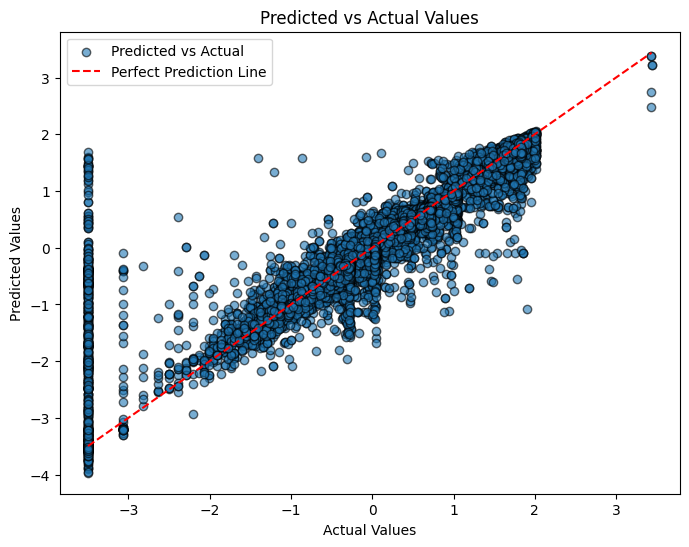

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_train_scaled, y_pred, alpha=0.6, edgecolors='k', label='Predicted vs Actual')
plt.plot([min(y_train_scaled), max(y_train_scaled)], [min(y_train_scaled), max(y_train_scaled)], 'r--', label='Perfect Prediction Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculating metrics
mse = mean_squared_error(y_train_scaled, y_pred)
mae = mean_absolute_error(y_train_scaled, y_pred)
r2 = r2_score(y_train_scaled, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")



Mean Squared Error (MSE): 0.15
Mean Absolute Error (MAE): 0.15
R-squared (R²): 0.85


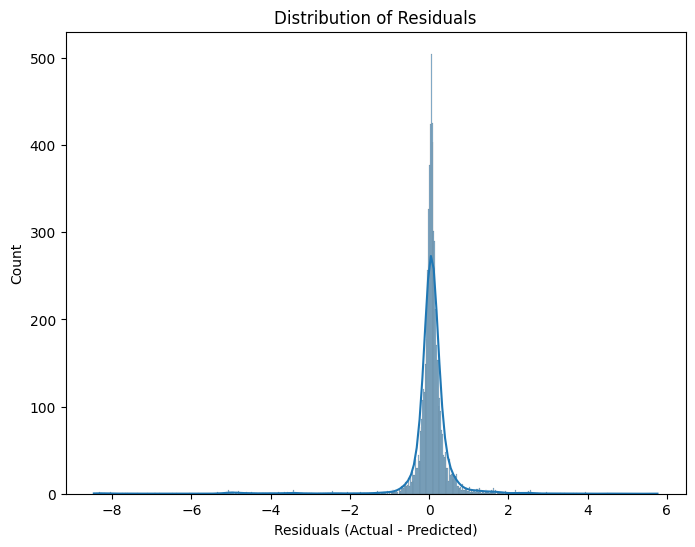

In [ ]:
import seaborn as sns

# Calculating residuals
residuals = y_train_scaled - y_pred

# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Distribution of Residuals")
plt.show()


In [13]:
# Feature importance (only if using tree-based model like XGBoost)
importances = best_xgb_model.feature_importances_

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, tick_label=X_train_cleaned.columns)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Trained Model")
plt.show()


NameError: name 'X_train_cleaned' is not defined

<Figure size 1000x600 with 0 Axes>

In [146]:
# featue engineering

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance from the trained model
feature_importance = pd.Series(best_xgb_model.feature_importances_, index=X_train_cleaned.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


NameError: name 'X_train_cleaned' is not defined

## integration

In [24]:
# Import necessary libraries
import chess
import chess.engine
import numpy as np
import xgboost as xgb
import pickle
from sklearn.preprocessing import LabelEncoder

# Paths to models and encoder files
piece_model_path = r"C:\Users\shaik\Desktop\piece_position_model.json"  # Path to your piece position model
time_model_path = r"C:\Users\shaik\Desktop\time_v2.json"  # Path to your time prediction model
encoder_path = r"C:\Users\shaik\Desktop\move_encoder.pkl"  # Path to your move label encoder

# Load Piece Position Model (e.g., XGBoost model)
piece_model = xgb.Booster()
piece_model.load_model(piece_model_path)

# Load Time Model (e.g., XGBoost model)
time_model = xgb.Booster()
time_model.load_model(time_model_path)

# Load move label encoder
with open(encoder_path, 'rb') as f:
    move_encoder = pickle.load(f)

# Path to the Stockfish executable
stockfish_path = r"C:\Users\shaik\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

print("Piece model, time model, move encoder, and chess engine loaded successfully.")


Piece model, time model, move encoder, and chess engine loaded successfully.


In [28]:
# Define a function to extract features from the board state
def board_to_features(board):
    """Convert the board state into a feature vector."""
    piece_mapping = {
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        '.': 0  # Empty squares
    }
    features = []
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        features.append(piece_mapping[piece.symbol()] if piece else 0)
    return np.array(features)

# Determine the game phase based on move count
def determine_game_phase(move_count):
    if move_count <= 15:
        return 1  # Opening
    elif move_count <= 40:
        return 2  # Middlegame
    else:
        return 3  # Endgame

# Define Piece Model feature extraction
def extract_features_for_piece_model(board, player_id, move_count):
    board_features = board_to_features(board)
    game_phase = determine_game_phase(move_count)
    # Example: Piece Model may use board state + game phase + player ID
    features = np.hstack([board_features, game_phase, player_id])
    return features

# Define Time Model feature extraction with only the features it was trained on
def extract_features_for_time_model(board, game_mode_encoded, white_time_left, black_time_left, total_seconds, move_count):
    # GameModeEncoded
    game_mode_encoded = np.array([game_mode_encoded])

    # WhiteTimeLeftProcessed and BlackTimeLeftProcessed
    white_time_left_processed = np.array([white_time_left])
    black_time_left_processed = np.array([black_time_left])

    # TotalSeconds (time control)
    total_seconds = np.array([total_seconds])

    # GamePhase and PieceCount
    game_phase = determine_game_phase(move_count)
    piece_count = 32 - move_count  # Approximate pieces remaining based on move count

    # Stack all features into a single array for the Time Model
    features = np.hstack([
        game_mode_encoded,
        white_time_left_processed,
        black_time_left_processed,
        total_seconds,
        game_phase,
        piece_count
    ])
    return features

print("Feature extraction functions defined.")


Feature extraction functions defined.


In [33]:
# Function to get top moves from Stockfish
def get_top_moves(board, top_n=10):
    """Get the top N moves from Stockfish."""
    result = engine.analyse(board, chess.engine.Limit(depth=10), multipv=top_n)
    top_moves_uci = [info['pv'][0] for info in result if info['pv'][0] in board.legal_moves]
    return top_moves_uci
def predict_move_and_time(board, player_id, move_count, game_mode_encoded, white_time_left, black_time_left, total_seconds):
    # Get top 10 moves from Stockfish
    top_moves_uci = get_top_moves(board, top_n=10)

    # Prepare features for each model
    piece_model_features = []
    time_model_features = []

    for move_uci in top_moves_uci:
        board.push(move_uci)

        # Features for Piece Model
        piece_features = extract_features_for_piece_model(board, player_id, move_count)
        piece_model_features.append(piece_features)

        # Features for Time Model (specific to the 6 required fields)
        time_features = extract_features_for_time_model(board, game_mode_encoded, white_time_left, black_time_left, total_seconds, move_count)
        time_model_features.append(time_features)

        board.pop()

    # Create DMatrix for each model
    piece_dmatrix = xgb.DMatrix(np.array(piece_model_features))
    time_dmatrix = xgb.DMatrix(np.array(time_model_features))

    # Predict move using the Piece Model
    move_predictions = piece_model.predict(piece_dmatrix)
    best_move_index = np.argmax(move_predictions)
    best_move = top_moves_uci[best_move_index]

    # Predict time taken using the Time Model
    time_prediction = time_model.predict(time_dmatrix)[best_move_index]
    predicted_time = np.expm1(time_prediction)  # Reverse log transformation if applied during training

    # Check if the predicted move is legal
    if best_move not in board.legal_moves:
        print("Predicted move is illegal. Choosing next best move.")
        for idx in range(1, len(move_predictions)):
            best_move_index = np.argsort(move_predictions)[-idx]
            best_move = top_moves_uci[best_move_index]
            if best_move in board.legal_moves:
                break
        else:
            print("No legal moves found from predictions.")
            return None, None  # No legal moves available

    # Print and return the results
    print(f"Predicted Move: {board.san(best_move)}, Predicted Time Taken: {predicted_time:.2f} seconds")
    return best_move, predicted_time


print("Move and time prediction function defined.")


Move and time prediction function defined.


In [35]:
import pandas as pd
import chess
import chess.engine
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data_path = r"C:\Users\shaik\Desktop\updated_time_control_rest_1.csv"
df = pd.read_csv(data_path)

# Ensure 'GameModeEncoded' exists by encoding 'GameMode' if needed
if 'GameModeEncoded' not in df.columns:
    game_mode_encoder = LabelEncoder()
    df['GameModeEncoded'] = game_mode_encoder.fit_transform(df['GameMode'])

# Ensure 'WhiteTimeLeftProcessed' and 'BlackTimeLeftProcessed' are processed if not present
def process_time_column(time_column):
    processed_times = []
    for time_data in time_column:
        if isinstance(time_data, str):
            try:
                time_list = ast.literal_eval(time_data)
                processed_times.append(np.mean([int(float(t)) for t in time_list]))
            except (ValueError, SyntaxError):
                processed_times.append(0)
        elif isinstance(time_data, list):
            processed_times.append(np.mean([int(float(t)) for t in time_data]))
        else:
            processed_times.append(0)
    return processed_times

if 'WhiteTimeLeftProcessed' not in df.columns:
    df['WhiteTimeLeftProcessed'] = process_time_column(df['WhiteTimeLeft'])
if 'BlackTimeLeftProcessed' not in df.columns:
    df['BlackTimeLeftProcessed'] = process_time_column(df['BlackTimeLeft'])

# Select a specific row/game from the dataset to play (e.g., first game)
game_data = df.iloc[0]

# Extract required features from the dataset
game_mode_encoded = game_data['GameModeEncoded']
white_time_left = game_data['WhiteTimeLeftProcessed']
black_time_left = game_data['BlackTimeLeftProcessed']
total_seconds = game_data['TotalSeconds']

# Initialize the chess board
board = chess.Board()
selected_player_id = 0  # Set your player ID as needed
move_count = 0  # Track the number of moves made

# Main game loop using features from the dataset
while not board.is_game_over():
    print("\nCurrent Board Position:")
    print(board)
    
    if board.turn == chess.WHITE:
        print("White's move (Human):")
        legal_moves = [board.san(move) for move in board.legal_moves]
        print("Legal moves:", legal_moves)
        user_move = input("Your move (SAN format): ")
        
        # Validate user move
        while user_move not in legal_moves:
            print("Invalid move. Please choose from the legal moves shown above.")
            user_move = input("Your move (SAN format): ")
        
        # Make the move
        board.push_san(user_move)
    else:
        print("Black's move (AI):")
        # AI predicts move and time taken with dataset values
        best_move, predicted_time = predict_move_and_time(
            board, selected_player_id, move_count, 
            game_mode_encoded, white_time_left, black_time_left, total_seconds
        )

        # Check if a valid move was returned
        if best_move is not None:
            # Apply the predicted move
            board.push(best_move)
            print(f"AI (Black) chose move: {board.san(best_move)} (Time Taken: {predicted_time:.2f} seconds)")
        else:
            print("AI could not find a valid move.")
            break

    # Increment move count
    move_count += 1

# End the game
print("\nGame Over!")
print("Final Board:")
print(board)
print("Result:", board.result())



Current Board Position:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
White's move (Human):
Legal moves: ['Nh3', 'Nf3', 'Nc3', 'Na3', 'h3', 'g3', 'f3', 'e3', 'd3', 'c3', 'b3', 'a3', 'h4', 'g4', 'f4', 'e4', 'd4', 'c4', 'b4', 'a4']

Current Board Position:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
Black's move (AI):
Predicted Move: d6, Predicted Time Taken: -0.41 seconds


AssertionError: san() and lan() expect move to be legal or null, but got d7d6 in rnbqkbnr/ppp1pppp/3p4/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import chess
import chess.engine

# Assuming you have your models trained and ready
# Load your piece prediction model and time prediction model
piece_model_path= r"C:\Users\shaik\Desktop\50_player_code.json" # Update with your piece model path
time_model_path = r"C:\Users\shaik\Desktop\time_v1.json"  # Update with your time model path
piece_model = xgb.Booster()
piece_model.load_model(piece_model_path)

time_model = xgb.Booster()
time_model.load_model(time_model_path)

# Initialize chess engine
stockfish_path = r"C:\Users\shaik\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

# Function to extract board features for the model
def board_to_features(board):
    piece_mapping = {
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        '.': 0
    }
    features = []
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        features.append(piece_mapping[piece.symbol()] if piece else 0)
    return np.array(features)

# Function to predict the best piece move
def predict_piece_move(board, player_id):
    board_features = board_to_features(board).reshape(1, -1)  # Reshape for the model
    dmatrix = xgb.DMatrix(board_features)
    piece_prediction = piece_model.predict(dmatrix)
    return piece_prediction  # Returning the predicted piece

# Function to use Stockfish to get the top 10 moves and select the best one according to the model
def select_best_move(board, player_id, game_phase):
    # Get top 10 moves from Stockfish
    result = engine.analyse(board, chess.engine.Limit(depth=10), multipv=10)
    
    # Collect Stockfish's top moves in SAN format
    stockfish_moves_san = [board.san(info['pv'][0]) for info in result if info['pv'][0] in board.legal_moves]
    stockfish_moves_uci = [info['pv'][0] for info in result if info['pv'][0] in board.legal_moves]

    # Predict the piece to move
    predicted_piece = predict_piece_move(board, player_id)

    # Convert SAN moves to the format the model expects for evaluation
    features_list = []
    for move_uci in stockfish_moves_uci:
        board.push(move_uci)
        features = extract_features(board, player_id, game_phase)  # Get existing features
        features = np.append(features, predicted_piece)  # Add the predicted piece
        features_list.append(features)
        board.pop()

    # Predict with the model
    dmatrix = xgb.DMatrix(np.array(features_list))
    predictions = time_model.predict(dmatrix)
    best_move_index = np.argmax(predictions)
    best_move_san = stockfish_moves_san[best_move_index]
    best_move_uci = stockfish_moves_uci[best_move_index]

    # Final legality check and applying move in SAN format
    try:
        if best_move_uci in board.legal_moves:
            board.push(best_move_uci)
            display_board_and_legal_moves(board)  # Update the board display
            return best_move_uci
        else:
            print("Selected move is not legal after verification.")
            return None
    except Exception as e:
        print(f"Error applying AI move: {e}")
        return None

# Game loop will remain the same


In [ ]:
import chess
import chess.engine
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle

# Load the trained XGBoost model
model_path = r"C:\Users\shaik\Desktop\50_player_code.json"  # Update with your model path
bst = xgb.Booster()
bst.load_model(model_path)

# Load the move label encoder
encoder_path = r"C:\Users\shaik\Desktop\move_encoder.pkl"  # Update with your encoder path
with open(encoder_path, 'rb') as f:
    move_encoder = pickle.load(f)

# Path to the Stockfish executable
stockfish_path = r"C:\Users\shaik\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

# Initialize the chess board
board = chess.Board()

# Load dataset to initialize player encoder
data_path = r"C:\Users\shaik\Desktop\updated_time_control_rest_1.csv"  # Update this path if needed
df = pd.read_csv(data_path)
top_50_players = pd.concat([df['White'], df['Black']]).value_counts().head(50).index.tolist()

# Initialize and fit player encoder
player_encoder = LabelEncoder()
all_players = pd.concat([df['White'], df['Black']]).unique()
player_encoder.fit([player.lower() for player in all_players])

# Choose a player from the top 50
selected_player = top_50_players[0]  # For example, selecting the first player
selected_player_id = player_encoder.transform([selected_player.lower()])[0]

# Function to extract board features for the model
def board_to_features(board):
    piece_mapping = {
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        '.': 0
    }
    features = []
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        features.append(piece_mapping[piece.symbol()] if piece else 0)
    return np.array(features)

# Function to extract features for the model
def extract_features(board, player_id, game_phase):
    board_features = board_to_features(board)
    return np.hstack([board_features, game_phase, player_id])

# Function to display board and available legal moves in SAN format
def display_board_and_legal_moves(board):
    print("\nCurrent Board Position:")
    print(board)
    legal_moves = [board.san(move) for move in board.legal_moves]
    print("Legal moves:", legal_moves)
    return legal_moves

# Function to use Stockfish to get the top 10 moves and select the best one according to the model
def select_best_move(board, player_id, game_phase):
    # Get top 10 moves from Stockfish
    result = engine.analyse(board, chess.engine.Limit(depth=10), multipv=10)
    
    # Collect Stockfish's top moves in SAN format for easier debugging
    stockfish_moves_san = [board.san(info['pv'][0]) for info in result if info['pv'][0] in board.legal_moves]
    stockfish_moves_uci = [info['pv'][0] for info in result if info['pv'][0] in board.legal_moves]

    # Print Stockfish's top moves in both SAN and UCI formats
    print("Stockfish's Top 10 Moves (SAN):", stockfish_moves_san)
    print("Stockfish's Top 10 Moves (UCI):", stockfish_moves_uci)

    # Convert SAN moves to the format the model expects for evaluation
    features_list = []
    for move_uci in stockfish_moves_uci:
        board.push(move_uci)
        features = extract_features(board, player_id, game_phase)
        features_list.append(features)
        board.pop()

    # Predict with the model
    dmatrix = xgb.DMatrix(np.array(features_list))
    predictions = bst.predict(dmatrix)
    best_move_index = np.argmax(predictions)
    best_move_san = stockfish_moves_san[best_move_index]
    best_move_uci = stockfish_moves_uci[best_move_index]

    # Final legality check and applying move in SAN format
    try:
        print(f"Model selected move (SAN): {best_move_san}")
        if best_move_uci in board.legal_moves:
            board.push(best_move_uci)
            print(f"AI's move applied: {best_move_san}")
            display_board_and_legal_moves(board)
            return best_move_uci
        else:
            print("Selected move is not legal after verification.")
            return None
    except Exception as e:
        print(f"Error applying AI move: {e}")
        return None

# Display the initial board and legal moves
display_board_and_legal_moves(board)

# Main game loop
while not board.is_game_over():
    # White's turn (User)
    if board.turn == chess.WHITE:
        legal_moves = display_board_and_legal_moves(board)
        user_move = input("Your move in SAN (choose from legal moves shown above): ")
        while user_move not in legal_moves:
            print("Invalid move. Please choose from the legal moves shown above.")
            user_move = input("Your move in SAN (choose from legal moves shown above): ")

        try:
            board.push_san(user_move)
            print("User move applied:", user_move)
            display_board_and_legal_moves(board)
        except Exception as e:
            print(f"Error: {e}. Please try again.")
            continue

    # Black's turn (AI)
    else:
        try:
            move_count = len(board.move_stack)
            game_phase = 1 if move_count <= 15 else (2 if move_count <= 40 else 3)

            # Select AI's move based on model and Stockfish
            print("AI is calculating its move...")
            select_best_move(board, selected_player_id, game_phase)

        except Exception as e:
            print(f"Error during AI move calculation: {e}")
            break

# End the game
print("Game Over!")
print("Final Board:")
print(board)
print("Result:", board.result())



Current Board Position:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Legal moves: ['Nh3', 'Nf3', 'Nc3', 'Na3', 'h3', 'g3', 'f3', 'e3', 'd3', 'c3', 'b3', 'a3', 'h4', 'g4', 'f4', 'e4', 'd4', 'c4', 'b4', 'a4']

Current Board Position:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Legal moves: ['Nh3', 'Nf3', 'Nc3', 'Na3', 'h3', 'g3', 'f3', 'e3', 'd3', 'c3', 'b3', 'a3', 'h4', 'g4', 'f4', 'e4', 'd4', 'c4', 'b4', 'a4']
User move applied: e3

Current Board Position:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R
Legal moves: ['Nh6', 'Nf6', 'Nc6', 'Na6', 'h6', 'g6', 'f6', 'e6', 'd6', 'c6', 'b6', 'a6', 'h5', 'g5', 'f5', 'e5', 'd5', 'c5', 'b5', 'a5']
AI is calculating its move...
Stockfish's Top 10 Moves (SAN): ['e5', 'Nf6', 'd5', 'e6', 'c5', 'g6', 'c6',

In [2]:
import chess
import chess.engine
import numpy as np
import xgboost as xgb
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the trained XGBoost model for move prediction
model_path = r"C:\Users\shaik\Desktop\50_player_code.json"  # Update with your model path
bst = xgb.Booster()
bst.load_model(model_path)

# Load the move label encoder
encoder_path = r"C:\Users\shaik\Desktop\move_encoder.pkl"  # Update with your encoder path
with open(encoder_path, 'rb') as f:
    move_encoder = pickle.load(f)

# Load the time prediction model
time_model_path = r"C:\Users\shaik\Desktop\time_v1.json"  # Update with your time model path
time_model = xgb.Booster()
time_model.load_model(time_model_path)

# Path to the Stockfish executable
stockfish_path = r"C:\Users\shaik\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

# Initialize the chess board
board = chess.Board()

# Load dataset to initialize player encoder
data_path = r"C:\Users\shaik\Desktop\updated_time_control_rest_1.csv"  # Update this path if needed
df = pd.read_csv(data_path)
top_50_players = pd.concat([df['White'], df['Black']]).value_counts().head(50).index.tolist()

# Initialize and fit player encoder
player_encoder = LabelEncoder()
all_players = pd.concat([df['White'], df['Black']]).unique()
player_encoder.fit([player.lower() for player in all_players])

# Choose a player from the top 50
selected_player = top_50_players[0]  # For example, selecting the first player
selected_player_id = player_encoder.transform([selected_player.lower()])[0]

# Function to extract board features for the model
def board_to_features(board):
    piece_mapping = {
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        '.': 0
    }
    features = []
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        features.append(piece_mapping[piece.symbol()] if piece else 0)
    return np.array(features)

# Function to extract features for the model
def extract_features(board, player_id, game_phase):
    board_features = board_to_features(board)
    return np.hstack([board_features, game_phase, player_id])

# Function to display board and available legal moves in SAN format
def display_board_and_legal_moves(board):
    print("\nCurrent Board Position:")
    print(board)
    legal_moves = [board.san(move) for move in board.legal_moves]
    print("Legal moves:", legal_moves)
    return legal_moves

# Function to use Stockfish to get the top 10 moves and select the best one according to the model
def select_best_move(board, player_id, game_phase):
    # Get top 10 moves from Stockfish
    result = engine.analyse(board, chess.engine.Limit(depth=10), multipv=10)
    
    # Collect Stockfish's top moves in SAN format for easier debugging
    stockfish_moves_san = [board.san(info['pv'][0]) for info in result if info['pv'][0] in board.legal_moves]
    stockfish_moves_uci = [info['pv'][0] for info in result if info['pv'][0] in board.legal_moves]

    # Print Stockfish's top moves in both SAN and UCI formats
    print("Stockfish's Top 10 Moves (SAN):", stockfish_moves_san)
    print("Stockfish's Top 10 Moves (UCI):", stockfish_moves_uci)

    # Convert SAN moves to the format the model expects for evaluation
    features_list = []
    for move_uci in stockfish_moves_uci:
        board.push(move_uci)
        features = extract_features(board, player_id, game_phase)
        features_list.append(features)
        board.pop()

    # Predict with the model
    dmatrix = xgb.DMatrix(np.array(features_list))
    predictions = bst.predict(dmatrix)
    best_move_index = np.argmax(predictions)
    best_move_san = stockfish_moves_san[best_move_index]
    best_move_uci = stockfish_moves_uci[best_move_index]

    # Final legality check and applying move in SAN format
    try:
        print(f"Model selected move (SAN): {best_move_san}")
        if best_move_uci in board.legal_moves:
            board.push(best_move_uci)
            print(f"AI's move applied: {best_move_san}")
            display_board_and_legal_moves(board)
            return best_move_uci
        else:
            print("Selected move is not legal after verification.")
            return None
    except Exception as e:
        print(f"Error applying AI move: {e}")
        return None

# Function to predict time taken for a move
def predict_time_taken(board, player_id, game_phase):
    features = extract_features(board, player_id, game_phase)  # Extract features for the current state
    dmatrix = xgb.DMatrix(np.array([features]))  # Convert to DMatrix format for prediction
    predicted_time = time_model.predict(dmatrix)  # Predict the time taken for the move
    return predicted_time[0]

# Main game loop
while not board.is_game_over():
    # White's turn (User)
    if board.turn == chess.WHITE:
        legal_moves = display_board_and_legal_moves(board)
        user_move = input("Your move in SAN (choose from legal moves shown above): ")
        while user_move not in legal_moves:
            print("Invalid move. Please choose from the legal moves shown above.")
            user_move = input("Your move in SAN (choose from legal moves shown above): ")

        try:
            board.push_san(user_move)
            print("User move applied:", user_move)
            display_board_and_legal_moves(board)
        except Exception as e:
            print(f"Error: {e}. Please try again.")
            continue

    # Black's turn (AI)
    else:
        try:
            move_count = len(board.move_stack)
            game_phase = 1 if move_count <= 15 else (2 if move_count <= 40 else 3)

            # Select AI's move based on model and Stockfish
            print("AI is calculating its move...")
            best_move_uci = select_best_move(board, selected_player_id, game_phase)

            # Predict the time taken for the AI's move
            predicted_time = predict_time_taken(board, selected_player_id, game_phase)
            print(f"Predicted time for AI's move: {predicted_time:.2f} seconds")

        except Exception as e:
            print(f"Error during AI move calculation: {e}")
            break

# End the game
print("Game Over!")
print("Final Board:")
print(board)
print("Result:", board.result())

# Close the chess engine
engine.quit()


# Display the initial board and legal moves
display_board_and_legal_moves(board)

# Main game loop
while not board.is_game_over():
    # White's turn (User)
    if board.turn == chess.WHITE:
        legal_moves = display_board_and_legal_moves(board)
        user_move = input("Your move in SAN (choose from legal moves shown above): ")
        while user_move not in legal_moves:
            print("Invalid move. Please choose from the legal moves shown above.")
            user_move = input("Your move in SAN (choose from legal moves shown above): ")

        try:
            board.push_san(user_move)
            print("User move applied:", user_move)
            display_board_and_legal_moves(board)
        except Exception as e:
            print(f"Error: {e}. Please try again.")
            continue

    # Black's turn (AI)
    else:
        try:
            move_count = len(board.move_stack)
            game_phase = 1 if move_count <= 15 else (2 if move_count <= 40 else 3)

            # Select AI's move based on model and Stockfish
            print("AI is calculating its move...")
            best_move_uci = select_best_move(board, selected_player_id, game_phase)

            # Predict the time taken for the AI's move
            predicted_time = predict_time_taken(board, selected_player_id, game_phase)
            print(f"Predicted time for AI's move: {predicted_time:.2f} seconds")

        except Exception as e:
            print(f"Error during AI move calculation: {e}")
            break

# End the game
print("Game Over!")
print("Final Board:")
print(board)
print("Result:", board.result())

# Close the chess engine
engine.quit()



Current Board Position:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Legal moves: ['Nh3', 'Nf3', 'Nc3', 'Na3', 'h3', 'g3', 'f3', 'e3', 'd3', 'c3', 'b3', 'a3', 'h4', 'g4', 'f4', 'e4', 'd4', 'c4', 'b4', 'a4']
User move applied: e4

Current Board Position:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
Legal moves: ['Nh6', 'Nf6', 'Nc6', 'Na6', 'h6', 'g6', 'f6', 'e6', 'd6', 'c6', 'b6', 'a6', 'h5', 'g5', 'f5', 'e5', 'd5', 'c5', 'b5', 'a5']
AI is calculating its move...
Stockfish's Top 10 Moves (SAN): ['e5', 'c5', 'e6', 'Nc6', 'd6', 'd5', 'a6', 'g6', 'c6', 'h6']
Stockfish's Top 10 Moves (UCI): [Move.from_uci('e7e5'), Move.from_uci('c7c5'), Move.from_uci('e7e6'), Move.from_uci('b8c6'), Move.from_uci('d7d6'), Move.from_uci('d7d5'), Move.from_uci('a7a6'), Move.from_uci('g7g6'), Move.from_uci('c7c6'), Move.from_uci('h7h6')]
Model sel

EngineTerminatedError: engine event loop dead